In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
color = sns.color_palette()
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
import plotly.tools as tls
import warnings
warnings.filterwarnings('ignore')
import os
from nltk.corpus import stopwords
import string
import nltk
nltk.download('stopwords')
eng_stopwords = set(stopwords.words("english"))
pd.options.mode.chained_assignment = None

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
!unzip commonlitreadabilityprize.zip

Archive:  commonlitreadabilityprize.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [6]:
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df.head()

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845


In [3]:
df.dtypes

id                 object
url_legal          object
license            object
excerpt            object
target            float64
standard_error    float64
dtype: object

In [4]:
df.isnull().sum()

id                   0
url_legal         2004
license           2004
excerpt              0
target               0
standard_error       0
dtype: int64

In [5]:
# Removing unnecessary columns
df.drop(['url_legal', 'license'], axis=1, inplace=True)

In [6]:
df.head()

,id,excerpt,target,standard_error
0,c12129c31,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,Once upon a time there were Three Bears who li...,0.247197,0.510845


#EDA

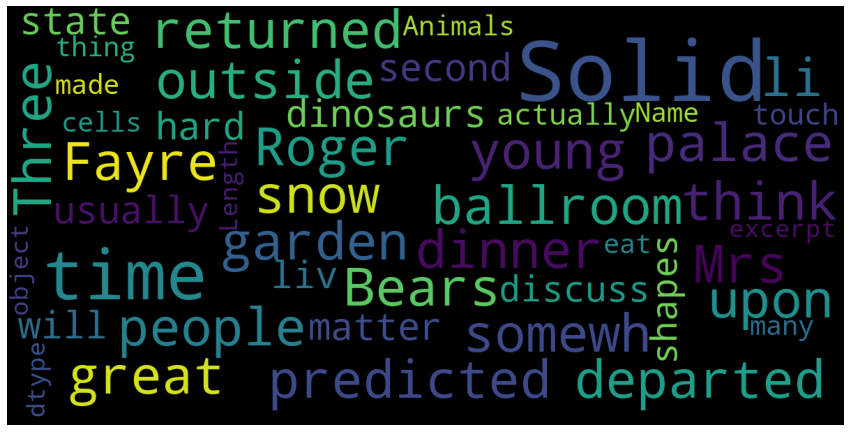

In [7]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(df['excerpt'])

Checking distribution of target variable

In [8]:
import plotly.express as px
fig = px.histogram(df, x="target")
fig.show()

Check length of passage with level of ease of reading passages


In [9]:
df['excerpt_length']=df['excerpt'].apply(len)

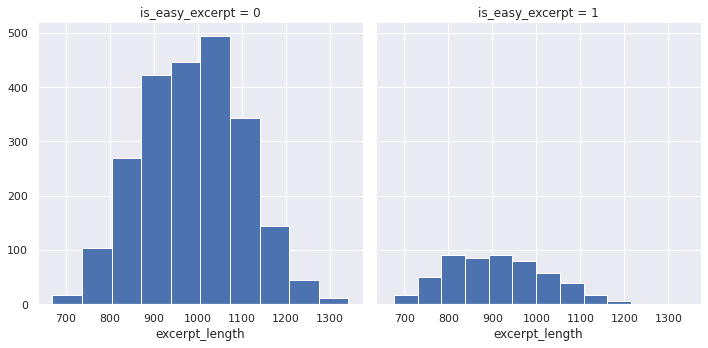

In [10]:
# create easy readability flag; 0 (difficult) - when target <= 0, 1 (easy) - when target > 0
df['is_easy_excerpt'] = np.where(df['target'] <= 0, 0, 1)

sns.set(font_scale=1.0)

g = sns.FacetGrid(df,col='is_easy_excerpt',size=5)
g.map(plt.hist,'excerpt_length')

# Feature Extraction


In [11]:
df["num_words"] = df["excerpt"].apply(lambda x: len(str(x).split()))

## Number of unique words in the text ##
df["num_unique_words"] = df["excerpt"].apply(lambda x: len(set(str(x).split())))

## Number of characters in the text ##
df["num_chars"] = df["excerpt"].apply(lambda x: len(str(x)))

## Number of stopwords in the text ##
df["num_stopwords"] = df["excerpt"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

## Number of punctuations in the text ##
df["num_punctuations"] =df['excerpt'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

## Number of title case words in the text ##
df["num_words_upper"] = df["excerpt"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Number of title case words in the text ##
df["num_words_title"] = df["excerpt"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

## Average length of the words in the text ##
df["mean_word_len"] = df["excerpt"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [12]:
df.head()

,id,excerpt,target,standard_error,excerpt_length,is_easy_excerpt,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,mean_word_len
0,c12129c31,When the young people returned to the ballroom...,-0.340259,0.464009,992,0,179,114,992,88,27,0,16,4.547486
1,85aa80a4c,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805,937,0,169,127,937,73,56,6,28,4.550296
2,b69ac6792,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676,908,0,166,128,908,75,47,2,29,4.475904
3,dd1000b26,And outside before the palace a great garden w...,-1.054013,0.450007,909,0,164,118,909,70,33,0,8,4.548780
4,37c1b32fb,Once upon a time there were Three Bears who li...,0.247197,0.510845,723,1,147,51,723,75,32,0,42,3.925170


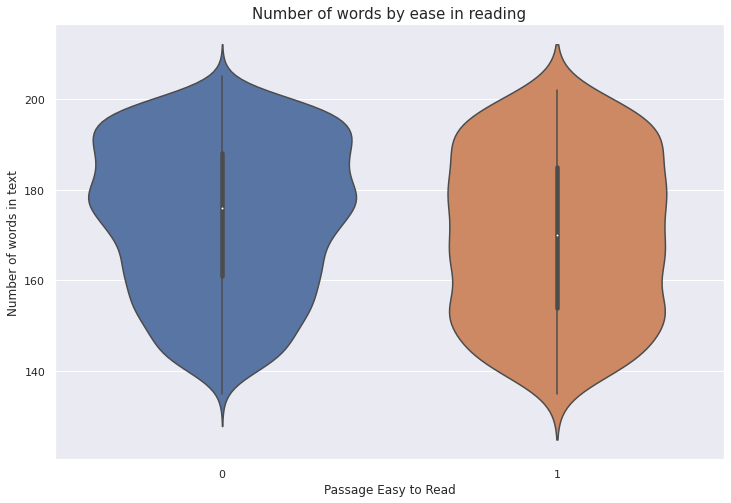

In [13]:
plt.figure(figsize=(12,8))
sns.violinplot(x='is_easy_excerpt', y='num_words', data=df)
plt.xlabel('Passage Easy to Read', fontsize=12)
plt.ylabel('Number of words in text', fontsize=12)
plt.title("Number of words by ease in reading", fontsize=15)
plt.show()

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

df['excerpt_id'] = df['is_easy_excerpt'].factorize()[0]
category_id_df = df[['is_easy_excerpt', 'excerpt_id']].drop_duplicates().sort_values('excerpt_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['excerpt_id', 'is_easy_excerpt']].values)

tfidf = TfidfVectorizer(sublinear_tf=True, 
                        norm='l2', 
                        encoding='latin-1', 
                        ngram_range=(1, 2), 
                        stop_words='english')

features = tfidf.fit_transform(df.excerpt)
labels = df.is_easy_excerpt
features.shape

from sklearn.feature_selection import chi2
import numpy as np

N = 2
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Product))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# '0':
  . Most correlated unigrams:
       . said
       . mother
  . Most correlated bigrams:
       . little boy
       . little girl
# '1':
  . Most correlated unigrams:
       . said
       . mother
  . Most correlated bigrams:
       . little boy
       . little girl


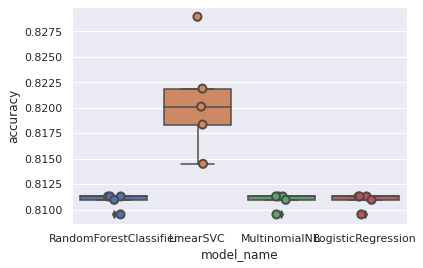

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

svm

In [16]:
test = pd.read_csv('test.csv')
test.head()

,id,url_legal,license,excerpt
0,c0f722661,NaN,NaN,My hope lay in Jack's promise that he would ke...
1,f0953f0a5,NaN,NaN,Dotty continued to go to Mrs. Gray's every nig...
2,0df072751,NaN,NaN,It was a bright and cheerful scene that greete...
3,04caf4e0c,https://en.wikipedia.org/wiki/Cell_division,CC BY-SA 3.0,Cell division is the process by which a parent...
4,0e63f8bea,https://en.wikipedia.org/wiki/Debugging,CC BY-SA 3.0,Debugging is the process of finding and resolv...


In [17]:
features_train = tfidf.fit_transform(df.excerpt)
features_test = tfidf.transform(test.excerpt)

labels = df['target']

from sklearn.model_selection import train_test_split
from sklearn.svm import SVR

model = SVR(C=10, kernel='rbf', gamma='auto')

X_train, X_test, y_train, y_test = train_test_split(features_train, labels, test_size=0.25, random_state=0)
model.fit(X_train, y_train)
y_repeat = model.predict(X_train)
y_val = model.predict(X_test)
y_preds = model.predict(features_test)

from sklearn.metrics import mean_squared_error

print('The RMSE for validation data is:', np.sqrt(mean_squared_error(y_repeat, y_train)))
print('The RMSE for validation data is:', np.sqrt(mean_squared_error(y_val, y_test)))

# The RMSE values prove that the model is not overfitting, however it needs a lot of improvement

test['target'] = y_preds
test[['id', 'target']].to_csv('submission.csv', index=False)

The RMSE for validation data is: 1.0327320933695314
The RMSE for validation data is: 1.0396984153178515


our score at Kaggle = 1.02 with SVM

The RMSE values prove that the model is not overfitting, however it needs a lot of improvement


#More EDA

## Searching and Finding in the min target value

In [18]:
df['target'].min()

-3.676267773

In [19]:
for word in df.loc[df['target'] == df['target'].min()].excerpt:
    print(word)

The commutator is peculiar, consisting of only three segments of a copper ring, while in the simplest of other continuous current generators several times that number exist, and frequently 120! segments are to be found. These three segments are made so as to be removable in a moment for cleaning or replacement. They are mounted upon a metal support, and are surrounded on all sides by a free air space, and cannot, therefore, lose their insulated condition. This feature of air insulation is peculiar to this system, and is very important as a factor in the durability of the commutator. Besides this, the commutator is sustained by supports carried in flanges upon the shaft, which flanges, as an additional safeguard, are coated all over with hard rubber, one of the finest known insulators. It may be stated, without fear of contradiction, that no other commutator made is so thoroughly insulated and protected. The three commutator segments virtually constitute a single copper ring, mounted in

In [20]:
df['target'].max()

1.7113898269999999

In [21]:
for word in df.loc[df['target'] == df['target'].max()].excerpt:
    print(word)

When you think of dinosaurs and where they lived, what do you picture? Do you see hot, steamy swamps, thick jungles, or sunny plains? Dinosaurs lived in those places, yes. But did you know that some dinosaurs lived in the cold and the darkness near the North and South Poles?
This surprised scientists, too. Paleontologists used to believe that dinosaurs lived only in the warmest parts of the world. They thought that dinosaurs could only have lived in places where turtles, crocodiles, and snakes live today. Later, these dinosaur scientists began finding bones in surprising places.
One of those surprising fossil beds is a place called Dinosaur Cove, Australia. One hundred million years ago, Australia was connected to Antarctica. Both continents were located near the South Pole. Today, paleontologists dig dinosaur fossils out of the ground. They think about what those ancient bones must mean.


# Data Preprocessing and Data clearning

In [3]:
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 827.9 MB 1.5 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


## Generating a new column clean excerpt, remove all punctuations, removing any links, numbers and stopwords

In [22]:
import spacy
import string
import re
import math

nlp = spacy.load('en_core_web_lg')
from spacy import displacy

# Function to up url_legal category
def clean_url(data):
    if type(data) == float:
        return "None"
    else:
        data = re.sub(r"https://|/wiki/|/|.org|pdf|wp-cont|-|%20|%|www.|frym.", " ", data)
        data = re.sub("[^a-zA-Z -]", " ", data.lower())
        data = re.sub("\s+", " ", data)
    return data

# Function to clean up text category
def clean_text(data):
    if type(data) == float:
        pass
    else:
        data = re.sub(r'\n|\\', " ", data.lower())
        data = re.sub("[^a-zA-Z]", " ", data.lower())
        data = re.sub("\s+", " ", data)
    return data

# Function to get sentences from input text
def get_sentences(data):
    row_doc = nlp(data)
    sents = list(row_doc.sents)
    return sents
# This will probably nor be helpful in this case, more useful for sentiment than complexity

# Function to generate tokens from input text
def gen_tokens(data):
    row_doc = nlp(data)
    return row_doc

# Removes stop words from tokenized text
def remove_stopwords(data):
    n_list = []
    for i in data:
        n_list.append([j.vector for j in i if not j.is_stop])
    return n_list

def remove_stopwords_url(data):
    n_list = []
    for i in data:
        n_list.append([j.text for j in i if not j.is_stop])
    return n_list

## Size of vocabulary

In [24]:
from collections import Counter
results = Counter()
df['excerpt_clean'].str.lower().str.split().apply(results.update)
print(len(results.keys()))

26154


## Plotting Top bigram and ngram

In [25]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
def get_top_n_words(corpus, n = None):
    """
    A function that returns the top 'n' unigrams used in the corpus
    """
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus) 
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()] 
    freq_sorted = sorted(words_freq, key = lambda x: x[1], reverse = True)
    return freq_sorted[:n]

def get_top_n_bigram(corpus, n = None):
    """
    A function that returns the top 'n' bigrams used in the corpus
    """
    vec = CountVectorizer(ngram_range = (2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis = 0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    freq_sorted = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return freq_sorted[:n]

In [26]:
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource
from bokeh.io import curdoc, show, output_notebook
output_notebook()
top_unigram = get_top_n_words(df['excerpt_clean'], 20)
words = [i[0] for i in top_unigram]
count = [i[1] for i in top_unigram]
source = ColumnDataSource(data = dict(Word = words, counts = count, color = ['#6baed6'] * 20))

p = figure(x_range = words, plot_height = 400, plot_width = 800, title = "Top Unigrams", tools = "hover", tooltips = "@Word: @counts")
p.vbar(x = 'Word', top = 'counts', width = 0.8, source = source, color = 'color')
curdoc().theme = 'dark_minimal'
p.xgrid.grid_line_color = None
p.y_range.start = 0
p.title.align = 'center'
p.xaxis.major_label_orientation = "vertical"
show(p)

## Stemming

In [28]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer(language='english')


In [29]:
def stemWord(text):
    tokens = text.split()
    clean_text = ' '
    for token in tokens:
        clean_text = clean_text + " " + stemmer.stem(token)      
    
    return clean_text

In [30]:
df['excerpt_clean_stemming'] = df['excerpt_clean'].apply(stemWord)

#Using Spacy with Bi-LSTM

In [ ]:
# Split train into X and Y
X = train.drop(columns='target')
Y = train['target']

clean_text_train = [clean_text(i) for i in X['excerpt']]
clean_text_test = [clean_text(i) for i in test['excerpt']]

#clean_work = clean_text(work)

# Add cleaned columns back
# X['clean_url'] = clean_urls_train
X['clean_text'] = clean_text_train
# test['clean_url'] = clean_urls_test
test['clean_text'] = clean_text_test
# Generate tokens from clean_text
# train_url_tokens = remove_stopwords_url([gen_tokens(i) for i in X['clean_url']])
train_excerpt_tokens = remove_stopwords([gen_tokens(i) for i in X['clean_text']])
# test_url_tokens = remove_stopwords_url([gen_tokens(i) for i in test['clean_url']])
test_excerpt_tokens = remove_stopwords([gen_tokens(i) for i in test['clean_text']])


X['excerpt_tokens'] = train_excerpt_tokens

test['excerpt_tokens'] = test_excerpt_tokens

X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.1, random_state=42)
print("Train:",(X_train.shape, y_train.shape), "Val:",(X_val.shape, y_val.shape))

Train: ((2550, 7), (2550,)) Val: ((284, 7), (284,))


In [ ]:
X_train_vect = [np.array(i) for i in X_train['excerpt_tokens']]
X_val_vect = [np.array(i) for i in X_val['excerpt_tokens']]
test_vect = [np.array(i) for i in test['excerpt_tokens']]


In [ ]:
def pad_array(data):
    data_out = []
    for i in range(len(data)):
        an_array = data[i]
        shape = np.shape(an_array)
        padded_array = np.zeros((200,300))
        padded_array[:shape[0],:shape[1]] = an_array
        data_out.append(padded_array)
    return data_out

In [ ]:
cool_array_X = pad_array(X_train_vect)
cool_array_V = pad_array(X_val_vect)
cool_array_test = pad_array(test_vect)
t = np.array(cool_array_X).reshape(len(X_train), 200, 300)
v = np.array(cool_array_V).reshape(len(y_val), 200, 300)
vt = np.array(cool_array_test).reshape(len(test), 200, 300)


y = np.array(y_train)
y = y.reshape(1, -1)

In [ ]:
model1 = Sequential()

model1.add(Bidirectional(LSTM(512, input_shape=(None, 300), return_sequences=True),
                            backward_layer=LSTM(512, go_backwards=True, return_sequences=True)))

model1.add(Dense(128, activation='relu'))

model1.add(Dense(1))

model1.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])



In [ ]:
model1.fit(t, y_train,
           validation_data=(v, y_val),
           batch_size = 20,
           epochs=100,
           verbose=1,
           
          )

Epoch 1/100
128/128 [==============================] - 34s 200ms/step - loss: 0.9803 - mse: 0.9803 - val_loss: 0.7087 - val_mse: 0.7087
Epoch 2/100
128/128 [==============================] - 24s 191ms/step - loss: 0.7533 - mse: 0.7533 - val_loss: 0.9557 - val_mse: 0.9557
Epoch 3/100
128/128 [==============================] - 25s 192ms/step - loss: 0.8775 - mse: 0.8775 - val_loss: 0.7122 - val_mse: 0.7122
Epoch 4/100
128/128 [==============================] - 24s 190ms/step - loss: 0.7637 - mse: 0.7637 - val_loss: 0.8215 - val_mse: 0.8215
Epoch 5/100
128/128 [==============================] - 24s 191ms/step - loss: 0.7864 - mse: 0.7864 - val_loss: 1.0499 - val_mse: 1.0499
Epoch 6/100
128/128 [==============================] - 25s 192ms/step - loss: 0.7949 - mse: 0.7949 - val_loss: 0.7918 - val_mse: 0.7918
Epoch 7/100
128/128 [==============================] - 25s 192ms/step - loss: 0.7367 - mse: 0.7367 - val_loss: 0.7582 - val_mse: 0.7582
Epoch 8/100
128/128 [===========================

In [ ]:
model1.save('model1')

In [ ]:
l = model1.predict(vt)
f = [np.mean(i) for i in l]

In [ ]:
f

[-1.3602839,
 -0.7652048,
 -0.5913999,
 -2.105972,
 -1.4669632,
 -2.0891907,
 -0.45615074]

In [ ]:
submission['target'] = f

submission.to_csv("./submission.csv", index=False)

# Score with BiLSTM 0.666, a whole alot of improve

## Using Bert Transformer

In [2]:
import numpy as np 
import pandas as pd

In [4]:
!pip install transformers

In [5]:
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup

import torch
from torch.utils.data import DataLoader, Dataset, random_split

from sklearn.model_selection import train_test_split

In [7]:
def pad_to_len(seqs, to_len, padding=0):
    paddeds = []
    for seq in seqs:
        paddeds.append(
            seq[:to_len] + [padding] * max(0, to_len - len(seq))
        )
    return paddeds

In [8]:
class dataset(Dataset):
    def __init__(self, data):
        self.data  = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        sample = self.data[index]
        return sample
    
    def collate_fn(self, samples, target=True):

        batch = {}
        
        for key in ['input_ids', 'token_type_ids', 'attention_mask']:
            to_len = max([len(sample[key]) for sample in samples])
            padded = pad_to_len(
                [sample[key] for sample in samples], to_len, 0
            )
            batch[key] = torch.tensor(padded)
        
        if target:
            batch['label'] = torch.tensor([sample['target'] for sample in samples])
            
        return batch

In [22]:
class BERT(torch.nn.Module):
    def __init__(self):
        super().__init__()        
        self.model = BertModel.from_pretrained( "bert-base-uncased")
        self.extractor = torch.nn.Linear(768, 768)
        self.classifer = torch.nn.Linear(768, 1)
        self.dropout   = torch.nn.Dropout(0.1)
        self.tanh = torch.nn.Tanh() 
        
    def forward(self, ids, mask):
        output = self.model(ids, mask)
        CLS    = output.last_hidden_state[:,0,:]
        output = self.tanh(self.extractor(CLS))
        output = self.dropout(output)
        output = self.classifer(output)
        return output

In [10]:
class Estimator():
    def __init__(self, hyperparameters, device, model, optim = 'AdamW'):        
        self.params = hyperparameters
        self.model  = model
        self.device = device
        
        no_decay = ['bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in self.model.named_parameters() if not any(nd in n for nd in no_decay)], 
             'weight_decay': self.params['weight_decay']},
            {'params': [p for n, p in self.model.named_parameters() if any(nd in n for nd in no_decay)], 
             'weight_decay': 0.0}
        ]
        
        if optim == 'Adam':
            self.optimizer = torch.optim.Adam(params=optimizer_grouped_parameters, 
                                              lr=self.params['learning_rate'])
        if optim == 'AdamW':
            self.optimizer = torch.optim.AdamW(params=optimizer_grouped_parameters, 
                                              lr=self.params['learning_rate'])
        self.model.to(self.device)
        
    def load_weight(self, weight_path):
        self.model.load_state_dict(torch.load(weight_path))

    def fit(self, data, save_name):
        
        ## loss function
        criterion = torch.nn.MSELoss()
        criterion.to(self.device)

        ## Meta
        len_of_train = len(data['train'].dataset)
        len_of_test  = len(data['test'].dataset)
        best = 1000
        
        train_steps = int(len_of_train/self.params['batch_size']*self.params['epoch'])
        num_steps   = int(train_steps*0.1)

        scheduler = get_linear_schedule_with_warmup(self.optimizer, num_steps, train_steps)

        for epoch in range(self.params['epoch']):
            total_loss = 0
            total_val_loss = 0
            
            self.model.train()
            for batch in tqdm.tqdm(data['train']):
                ## INPUT
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                target = batch['label'].to(self.device)

                ## FOWARD
                output = self.model(input_ids, attention_mask)
                loss = criterion(output.squeeze(), target) ## LOSS and PREDICT
                total_loss+=loss.item()*len(input_ids)

                ## OPTIMIZE
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                scheduler.step() # Update learning rate schedule

            self.model.eval()
            for batch in data['test']:
                with torch.no_grad():
                    ## INPUT
                    input_ids = batch['input_ids'].to(self.device)
                    attention_mask = batch['attention_mask'].to(self.device)
                    target = batch['label'].to(self.device)

                    ## FOWARD
                    output = self.model(input_ids, attention_mask)
                    loss = criterion(output.squeeze(), target) ## LOSS and PREDICT
                    
                    total_val_loss+=loss.item()*len(input_ids)
                
            print(f'Epoch: {epoch}, Train: {(total_loss/len_of_train)**(1/2)}, Test: {(total_val_loss/len_of_test)**(1/2)}')

            if total_val_loss < best:
                best = total_val_loss
                torch.save(self.model.state_dict(), f"{save_name}.pth")
                    
    def inference(self, data, t = True):
        
        total_loss = 0
        outputs = []
        
        ## loss function
        criterion = torch.nn.MSELoss()
        criterion.to(self.device)
        
        self.model.eval()
        for batch in tqdm.tqdm(data):
            with torch.no_grad():
                ## INPUT
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                if t:
                    target = batch['label'].to(self.device)
                
                ## FOWARD
                output = self.model(input_ids, attention_mask)
                
                if t:
                    loss = criterion(output.squeeze(), target) ## LOSS and PREDICT
                    total_loss+=loss.item()*len(input_ids)
                
                outputs+=output.squeeze().tolist()
        
        if t:
            return (total_loss/len(data.dataset))**(1/2)
        else:
            return outputs

In [13]:
X_train, X_test, _, _ = train_test_split(df, df['target'], test_size=0.1, random_state=42)


X_train, X_valid, _, _ = train_test_split(X_train, X_train['target'], test_size=1/9, random_state=42)

X_train = X_train.reset_index(drop=True)
X_valid = X_valid.reset_index(drop=True)
X_test  = X_test.reset_index(drop=True)

datasets = {"train": X_train, "valid": X_valid, "test": X_test, "submit": df_test}

In [14]:
pretrained_bert = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(pretrained_bert, do_lower_case=True)

In [15]:
for key in datasets.keys():
    datasets[key]['input_ids'] = datasets[key]['excerpt'].apply(lambda x: tokenizer(x))
    datasets[key]['token_type_ids'] = datasets[key]['input_ids'].apply(lambda x: x['token_type_ids'])
    datasets[key]['attention_mask'] = datasets[key]['input_ids'].apply(lambda x: x['attention_mask'])
    datasets[key]['input_ids']      = datasets[key]['input_ids'].apply(lambda x: x['input_ids'])

In [17]:
train_dataset  = dataset(X_train.transpose().to_dict())
valid_dataset  = dataset(X_valid.transpose().to_dict())
test_dataset   = dataset(X_test.transpose().to_dict())
submit_dataset = dataset(df_test.transpose().to_dict())

In [18]:
BATCH_SIZE = 16
train_loader = DataLoader(
    dataset = train_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers=4,
    pin_memory=True,
    collate_fn = lambda x: dataset.collate_fn(train_dataset, x)
)

valid_loader = DataLoader(
    dataset = valid_dataset,
    batch_size = BATCH_SIZE,
    shuffle = False,
    num_workers=4,
    pin_memory=True,
    collate_fn = lambda x: dataset.collate_fn(valid_dataset, x)
)

test_loader = DataLoader(
    dataset = test_dataset,
    batch_size = BATCH_SIZE,
    shuffle = False,
    num_workers=4,
    pin_memory=True,
    collate_fn = lambda x: dataset.collate_fn(test_dataset, x)
)

submit_loader = DataLoader(
    dataset = submit_dataset,
    batch_size = BATCH_SIZE,
    shuffle = False,
    num_workers=4,
    pin_memory=True,
    collate_fn = lambda x: dataset.collate_fn(submit_dataset, x, target=False)
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [19]:
print(len(train_dataset), len(valid_dataset), len(test_dataset), len(submit_dataset))

2266 284 284 7


In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [23]:
estimator = Estimator(
    hyperparameters = {
        'learning_rate': 2e-5,
        'epoch': 5,
        'batch_size': BATCH_SIZE,
        'weight_decay':1e-2,
    }, 
    device = device,
    model = BERT()
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [25]:
import tqdm

estimator.fit({'train': train_loader, 
               'test': valid_loader},
              save_name='best_model')
estimator.load_weight('best_model.pth')
estimator.inference(test_loader)

  0%|          | 0/142 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 142/142 [03:16<00:00,  1.39s/it]


Epoch: 0, Train: 0.8690360231241028, Test: 0.6124805330158242


100%|██████████| 142/142 [03:17<00:00,  1.39s/it]


Epoch: 1, Train: 0.5010360345888139, Test: 0.7043183844946678


100%|██████████| 142/142 [03:17<00:00,  1.39s/it]


Epoch: 2, Train: 0.3826306114940801, Test: 0.6237571178448892


100%|██████████| 142/142 [03:17<00:00,  1.39s/it]


Epoch: 3, Train: 0.30514902722623294, Test: 0.5922866186455208


100%|██████████| 142/142 [03:17<00:00,  1.39s/it]


Epoch: 4, Train: 0.2597230395704148, Test: 0.644555415483205


100%|██████████| 18/18 [00:09<00:00,  1.96it/s]


0.5788806635042568

In [ ]:
X_valid['predict'] = estimator.inference(valid_loader, False)

In [ ]:
X_valid[['excerpt', 'target', 'predict']].sample(5)

In [ ]:
submit = pd.read_csv('../input/commonlitreadabilityprize/sample_submission.csv')
submit['target'] = estimator.inference(submit_loader, False)

In [ ]:
submit

# Bert Score = 0.59